# XRD Analysis Notebook

Extraction and transformation of X-ray diffraction collected on sub-100nm thin films, collected with Panalytical XRD Systems.
Weighted Lorentz and Gaussian fits applied for peak fitting.

## Extract Data from Exported .csv

In [125]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks
from scipy.optimize import curve_fit
import numpy as np
from scipy.ndimage import gaussian_filter1d

# Load the file and separate metadata from line scan data

file_path = "GV008_GSO_Wide.csv"
metadata = {}
scan_rows = []
in_scan_section = False

with open(file_path, "r") as f:
    for line in f:
        line = line.strip()

        # Detect start of scan section
        if line.startswith("[Scan points]"):
            in_scan_section = True
            continue

        # Parse metadata section
        if not in_scan_section:
            #if "," in line and not line.startswith("["):
            if not line.startswith("["):
                key, value = line.split(",", 1)
                metadata[key.strip()] = value.strip()
            continue

        # Parse scan data section
        if in_scan_section:
            if line.startswith("Angle"):
                continue
            if line:
                angle, intensity = line.split(",")
                scan_rows.append([float(angle), float(intensity)])

In [126]:
# Convert metadata to DataFrame
metadata_df = pd.DataFrame(list(metadata.items()), columns=["Field", "Value"])

# Convert line scan data to DataFrame
scan_df = pd.DataFrame(scan_rows, columns=["Angle", "Intensity"])

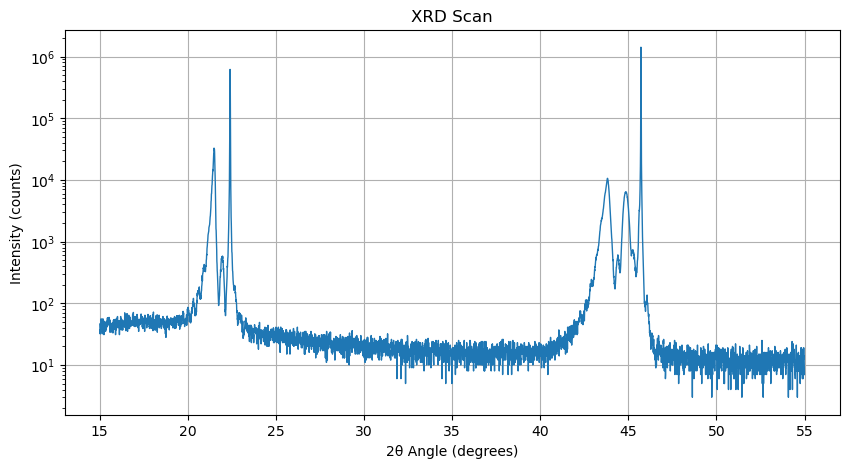

In [127]:
# Plot the XRD scan data
plt.figure(figsize=(10, 5))
plt.semilogy(scan_df["Angle"], scan_df["Intensity"], linewidth=1)
plt.xlabel("2θ Angle (degrees)")
plt.ylabel("Intensity (counts)")
plt.title("XRD Scan")
plt.grid(True)
plt.show()

In [128]:
# Print metadata
metadata_df

,Field,Value
0,Sample identification,
1,Comment - 1,"""Configuration=Main Configuration, Owner=User-..."
2,Comment - 2,"""Goniometer=HR HD (Theta/2Theta); Minimum step..."
3,Comment - 3,"""Sample stage=MRD Cradle; Minimum step size Ph..."
4,Comment - 4,"""Diffractometer system=XPERT-3"""
5,Comment - 5,"""Measurement program=C:\PANalytical\Data Colle..."
6,Anode material,Cu
7,K-Alpha1 wavelength,1.5405980
8,K-Alpha2 wavelength,1.5444260
9,Ratio K-Alpha2/K-Alpha1,0.500


## Preprocessing and Peak Fitting

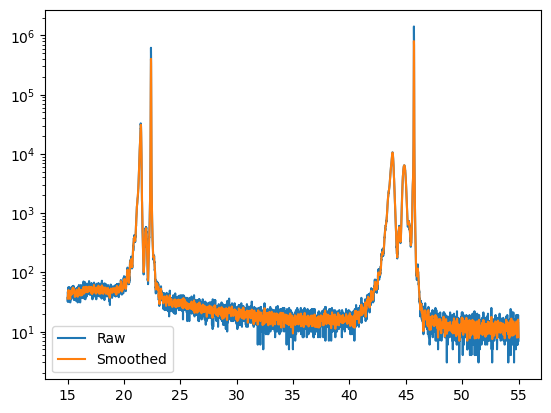

In [129]:
smoothed = gaussian_filter1d(scan_df.Intensity, sigma=1)
plt.semilogy(scan_df.Angle,scan_df.Intensity,label='Raw')
plt.semilogy(scan_df.Angle,smoothed,label='Smoothed')
plt.legend()

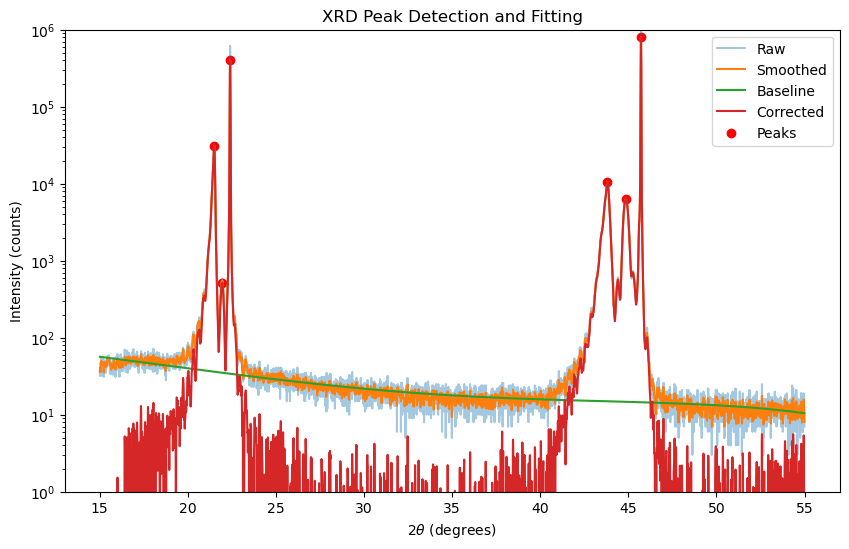

In [130]:
two_theta = scan_df.Angle

# Mask off peak locations for baseline fitting
mask = ~(((two_theta >= 20) & (two_theta <= 25)) |((two_theta >= 42) & (two_theta <= 48)))

coeffs = np.polyfit(two_theta[mask], smoothed[mask], deg=3)
baseline_poly = np.polyval(coeffs, two_theta)

corrected = smoothed - baseline_poly

# Identify peaks
peaks, props = find_peaks(corrected, prominence=400, distance=20)

# Fit peaks via Pseudo-Voigt
def pseudo_voigt(x, x0, A, sigma, eta):
    gaussian = A * np.exp(-(x - x0)**2 / (2 * sigma**2))
    lorentz = A * (sigma**2 / ((x - x0)**2 + sigma**2))
    return eta * lorentz + (1 - eta) * gaussian

fit_results = []

for p in peaks:
    # small window around peak
    left = max(0, p - 20)
    right = min(len(two_theta), p + 20)
    x = two_theta[left:right]
    y = corrected[left:right]

    # initial guesses
    x0_guess = two_theta[p]
    A_guess = corrected[p]
    sigma_guess = 0.05
    eta_guess = 0.5

    popt, _ = curve_fit(pseudo_voigt, x, y,p0=[x0_guess, A_guess, sigma_guess, eta_guess])

    fit_results.append(popt)

# Plot results
plt.figure(figsize=(10,6))
plt.ylim([1,1E6])
plt.semilogy(two_theta, scan_df.Intensity, label="Raw", alpha=0.4)
plt.semilogy(two_theta, smoothed, label="Smoothed")
plt.semilogy(two_theta, baseline_poly, label="Baseline")
plt.semilogy(two_theta, corrected, label="Corrected")

plt.scatter(two_theta[peaks], corrected[peaks], color='red', label="Peaks")

plt.xlabel(r"2$\theta$ (degrees)")
plt.ylabel("Intensity (counts)")
plt.legend()
plt.title("XRD Peak Detection and Fitting")
plt.show()


## Peak Fit Analysis

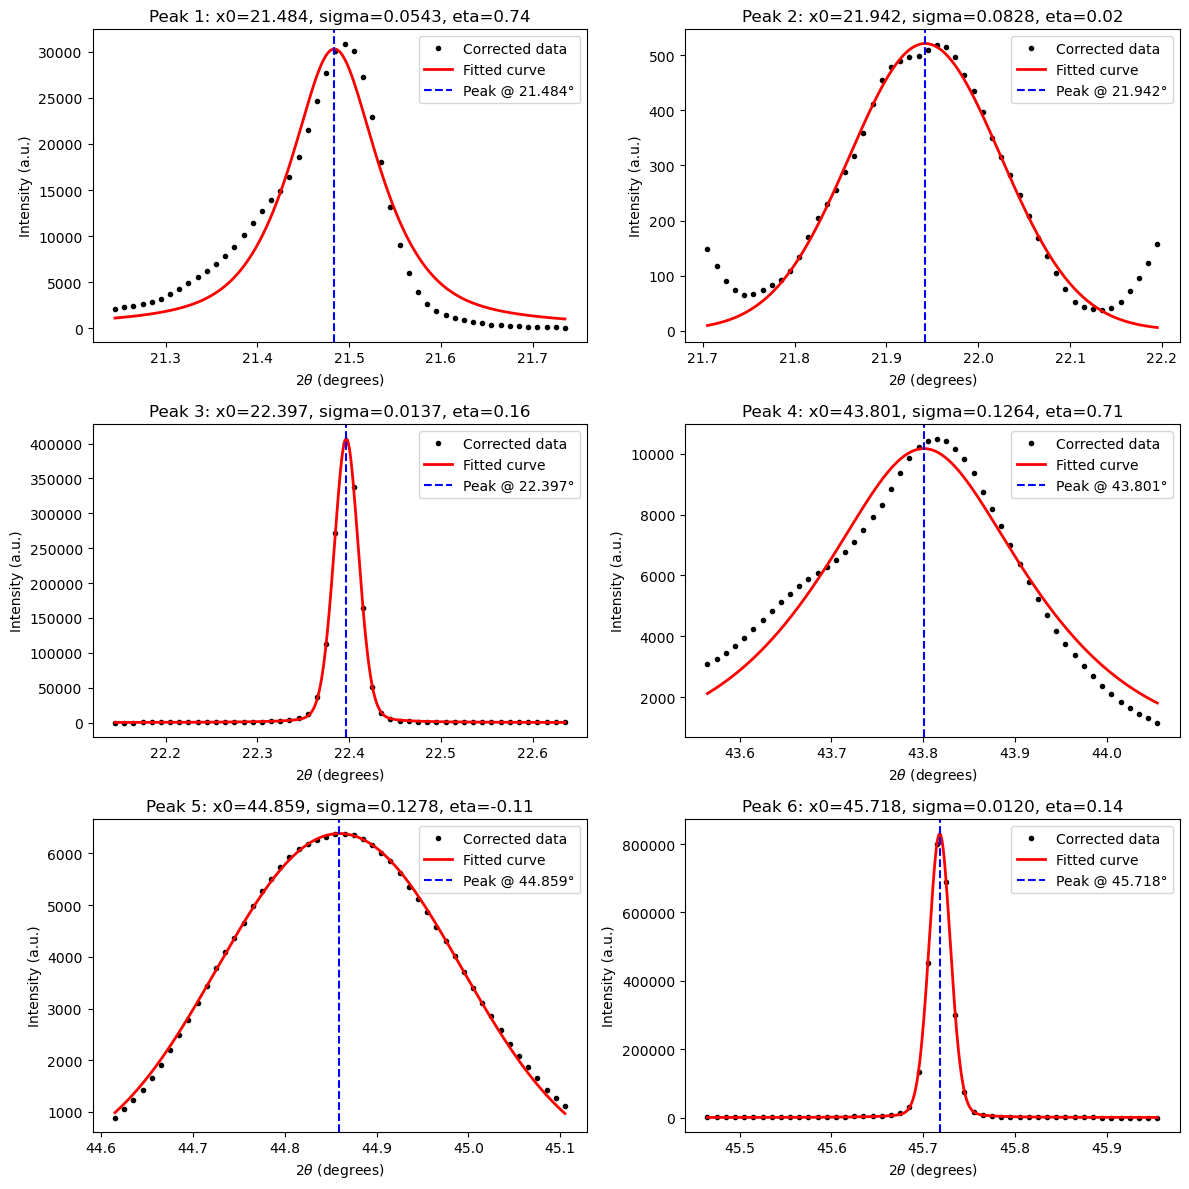

In [131]:
# Plot each peak using the fitted pop
def plot_peak_fits_from_popt(two_theta, corrected, peaks, fit_results, window=25):
    n_peaks = len(peaks)
    ncols = 2
    nrows = int(n_peaks / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4*nrows))
    axes = axes.flatten()

    for i, (p, popt) in enumerate(zip(peaks, fit_results)):
        ax = axes[i]

        # Local window around the peak
        left = max(0, p - window)
        right = min(len(two_theta), p + window)

        x = two_theta[left:right]
        y = corrected[left:right]

        # Generate fitted curve using popt
        x_fit = np.linspace(x.min(), x.max(), 400)
        y_fit = pseudo_voigt(x_fit, *popt)

        # Plot data + fit
        ax.plot(x, y, 'k.', label="Corrected data")
        ax.plot(x_fit, y_fit, 'r-', label="Fitted curve", linewidth=2)
        ax.axvline(popt[0], color='blue', linestyle='--', label=f"Peak @ {popt[0]:.3f}°")

        ax.set_title(f"Peak {i+1}: x0={popt[0]:.3f}, sigma={popt[2]:.4f}, eta={popt[3]:.2f}")
        ax.set_xlabel(r"2$\theta$ (degrees)")
        ax.set_ylabel("Intensity (a.u.)")
        ax.legend()

    # Hide unused subplots if odd number of peaks
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

plot_peak_fits_from_popt(two_theta, corrected, peaks, fit_results)
